<a href="https://colab.research.google.com/github/reachsidd/fina_project_6740/blob/main/python/FinalProject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import re
import string

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import sklearn.model_selection
nltk.download('punkt')
nltk.download('stopwords')
import bs4
import wordcloud

import keras.preprocessing
import tensorflow as tf
import zipfile
import sklearn.pipeline
import sklearn.model_selection
import pprint
import tensorflow.keras.preprocessing.text
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [114]:
# get raw text from htmls
def clean_html(text):
    soup = bs4.BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [115]:
# remove stopwords, punctuations and lower the case
def remove_stopwords_case_normalization(text):
    stopwords = nltk.corpus.stopwords.words('english')
    #print(stopwords)
    text_new = text.lower()
    text_new = re.sub('[^a-z]', ' ', text_new)
    # print(text_new)
    text_new = "".join([i for i in text_new if i not in string.punctuation])
    #print(text_new)
    words = text_new.split()
    #print(words)
    text_new = " ".join([i for i in words if i not in stopwords])
    #print(text_new)
    return text_new

In [116]:
def clean_text(text):
    # Remove urls
    text_new = re.sub(r'http\S+', '', text)
    text_new = clean_html(text_new)
    text_new = remove_stopwords_case_normalization(text_new)
    return text_new

# **1.    Exploratory Data Analysis (EDA)**







##Preparing the dataset

In [117]:
fake_github_url='https://github.com/reachsidd/fina_project_6740/blob/main/data/Fake.zip?raw=true'
true_github_url='https://github.com/reachsidd/fina_project_6740/blob/main/data/True.zip?raw=true'

fake_data_original = pd.read_csv(fake_github_url,compression='zip')
true_data_original = pd.read_csv(true_github_url,compression='zip')

# null check
print(fake_data_original.isna().sum())
# null check
print(true_data_original.isna().sum())


#true_data_original.head()

title      0
text       0
subject    0
date       0
dtype: int64
title      0
text       0
subject    0
date       0
dtype: int64


##Cleaning the data

In [118]:
fake_data = fake_data_original.copy()
true_data = true_data_original.copy()

fake_data['content'] = fake_data['title'] + ' ' + fake_data['text']
fake_data['label'] = 0
fake_data.drop(columns=['title', 'text', 'subject', 'date'], inplace=True)
#print(fake_data.head())

true_data['content'] = true_data['title'] + ' ' + true_data['text']
true_data['label'] = 1
true_data.drop(columns=['title', 'text', 'subject', 'date'], inplace=True)
#print(true_data.head())

fake_data['content'] = fake_data['content'].apply(clean_text)
#print(fake_data.head())

true_data['content'] = true_data['content'].apply(clean_text)
#print(true_data.head())



#FOR TESTING ONLY
#train = train.head(100)
#test = test.head(100)

## WORD CLOUD - True news

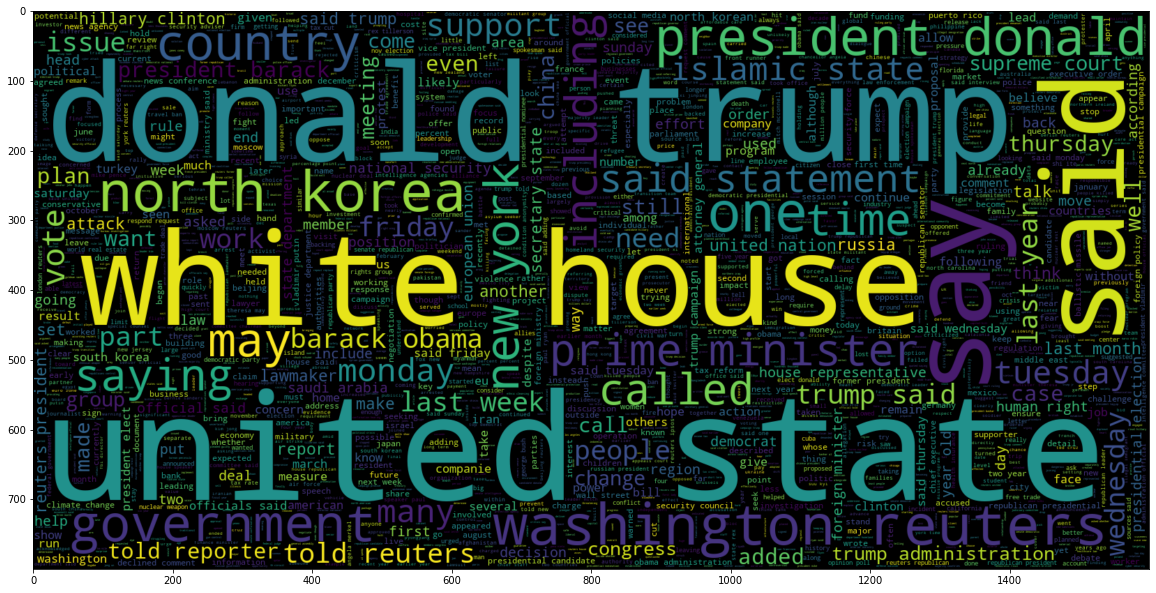

In [119]:
# WORDCLOUD FOR  CLEAN TEXT(LABEL - 1 - True)
plt.figure(figsize=(20, 20))  # Text that is not Fake
wc = wordcloud.WordCloud(max_words=2000, width=1600, height=800, stopwords=wordcloud.STOPWORDS).generate(" ".join(true_data.content))
plt.imshow(wc, interpolation='bilinear')
plt.show()

## WORD CLOUD - False news

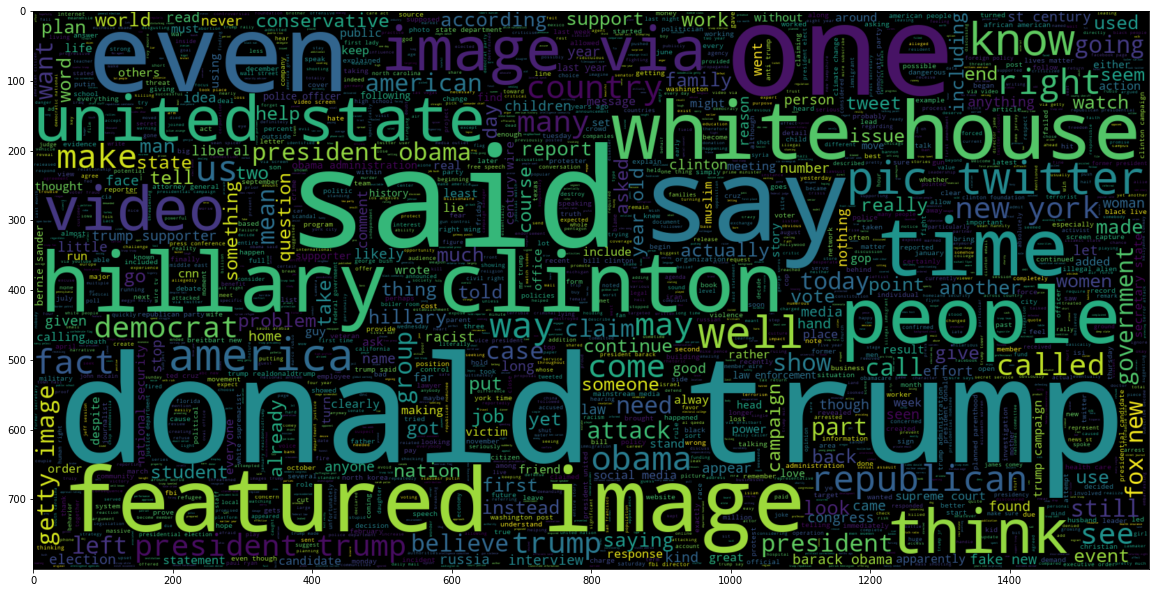

In [120]:
# WORDCLOUD FOR  FAKE TEXT(LABEL - 0 - fake)
plt.figure(figsize=(20, 20))  # Text that is Fake
wc = wordcloud.WordCloud(max_words=2000, width=1600, height=800, stopwords=wordcloud.STOPWORDS).generate(" ".join(fake_data.content))
plt.imshow(wc, interpolation='bilinear')
plt.show()

##Comparison of the top 10 most frequent words in news text between true & fake news

Index(['content', 'label', 'text_len'], dtype='object')


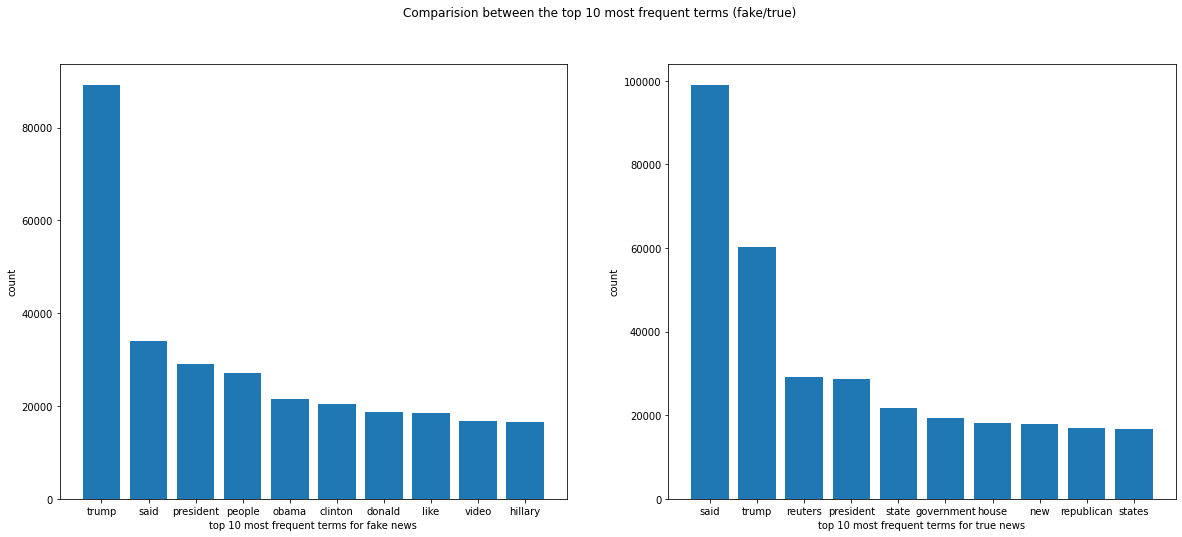

In [121]:
def get_top_n_words(corpus, n=None):
  corpus_fake = corpus[corpus['label'] == 0].astype(str)['content']
  corpus_true = corpus[corpus['label'] == 1].astype(str)['content']

  vec = sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english').fit(corpus_fake)
  bag_of_words = vec.transform(corpus_fake)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq_fake = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq_fake =sorted(words_freq_fake, key = lambda x: x[1], reverse=True)

  vec = sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english').fit(corpus_true)
  bag_of_words = vec.transform(corpus_true)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq_true = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq_true =sorted(words_freq_true, key = lambda x: x[1], reverse=True)

  df_fake = pd.DataFrame(words_freq_fake[:n],columns = ['text', 'count'])
  df_true = pd.DataFrame(words_freq_true[:n],columns = ['text', 'count'])

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
  ax1.bar(df_fake['text'], df_fake['count'])
  ax1.set_xticklabels(df_fake['text'])
  ax1.set(xlabel='top 10 most frequent terms for fake news', ylabel='count')
  ax2.bar(df_true['text'], df_true['count'])
  ax2.set_xticklabels(df_true['text'])
  ax2.set(xlabel='top 10 most frequent terms for true news', ylabel='count')
  plt.suptitle('Comparision between the top 10 most frequent terms (fake/true)')

  plt.show()

all_data = pd.concat([true_data,fake_data])
all_data['text_len'] = all_data['content'].apply(len)

print(all_data.columns)
get_top_n_words(corpus=all_data, n=10)


In [122]:
# NLP - Tokenize and apply Porter’s Stemmer algorithm
ps = nltk.stem.porter.PorterStemmer()

fake_data['content'] = fake_data['content'].apply(lambda x:' '.join([ps.stem(word) for word in nltk.tokenize.word_tokenize(x)]))
#print(fake_data.head())

true_data['content'] = true_data['content'].apply(lambda x:' '.join([ps.stem(word) for word in nltk.tokenize.word_tokenize(x)]))
#print(true_data.head())

In [123]:
fake_X_train, fake_X_test, fake_y_train, fake_y_test = sklearn.model_selection.train_test_split(fake_data['content'], fake_data['label'], test_size=0.2, random_state=42)
true_X_train, true_X_test, true_y_train, true_y_test = sklearn.model_selection.train_test_split(true_data['content'], true_data['label'], test_size=0.2, random_state=42)

X_train = np.concatenate((fake_X_train, true_X_train), axis=0)
X_test = np.concatenate((fake_X_test, true_X_test), axis=0)
y_train = np.concatenate((fake_y_train, true_y_train), axis=0)
y_test = np.concatenate((fake_y_test, true_y_test), axis=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35917,)
(8981,)
(35917,)
(8981,)


In [124]:
def load_up_classifier(classifier,classifier_cv_params:dict, X_train, X_test, y_train, y_test):
  pipeline = sklearn.pipeline.Pipeline([
                                        ('tfidfvect', sklearn.feature_extraction.text.TfidfVectorizer()),
                                        ('clfmodel', classifier),
                                        ])
  
  cv_params = {'tfidfvect__max_df': [0.25,0.5, 0.75, 1.0],}
  #cv_params = {'tfidfvect__max_df': [0.5],}

  for key in classifier_cv_params:
    new_key='clfmodel__'+key
    cv_params[new_key]=classifier_cv_params[key]
  
  print('cv_params=',cv_params)
  
  grid_search = sklearn.model_selection.GridSearchCV(pipeline, [cv_params], n_jobs=-1, verbose=1)
  
  print("Performing grid search...")
  #print("pipeline:", [name for name, _ in pipeline.steps])
  #print("parameters:")
  #pprint.pprint([cv_params])
  grid_search.fit(X_train, y_train)

  #print("Best score: %0.3f" % grid_search.best_score_)
  #print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  #print(best_parameters)
  kwargs ={}
  for key in cv_params:
    #print(key, best_parameters[key])
    kwargs[key]= best_parameters[key]

  #print(kwargs)

  pipeline.set_params(**kwargs)
  pipeline.fit(X_train, y_train)

  #print('pipeline.score=',pipeline.score(X_test,y_test))
  y_test_pred = pipeline.predict(X_test)
  #print(y_test_pred)
  accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred)
  precision, recall, fbeta_score,_ = sklearn.metrics.precision_recall_fscore_support(y_test, y_test_pred,average='micro')
  #print(accuracy, precision, recall, fbeta_score)

  return accuracy, precision, recall, fbeta_score

In [125]:
metrics={'classifier':[],'accuracy':[], 'precision':[], 'recall':[], 'fbeta_score':[]}



**1.   One hot encoding vectorizer and embedding layers with LSTM**



In [126]:
# Converting to one hot representation
voc_size=5000
maxlen = 25
kwargs={'n':voc_size}
print(X_train.shape)
#X_train_onehot_rep = np.apply_along_axis(tensorflow.keras.preprocessing.text.one_hot, 0,X_train,**kwargs)
X_train_onehot_rep = [tensorflow.keras.preprocessing.text.one_hot(words,voc_size) for words in X_train.tolist()]
X_test_onehot_rep = [tensorflow.keras.preprocessing.text.one_hot(words,voc_size) for words in X_test.tolist()]

#Padding Sentences to make them of same size
X_train_embedded_docs = np.array(tensorflow.keras.preprocessing.sequence.pad_sequences(X_train_onehot_rep,padding='pre',maxlen=maxlen))
X_test_embedded_docs = np.array(tensorflow.keras.preprocessing.sequence.pad_sequences(X_test_onehot_rep,padding='pre',maxlen=maxlen))

#We have used embedding layers with LSTM
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(voc_size, 40, input_length=maxlen))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#training model
model.fit(X_train_embedded_docs,y_train,epochs=20,batch_size=64)


y_train_pred_2 = (model.predict(X_train_embedded_docs) >0.5).astype("int32")
y_test_pred_2 = (model.predict(X_test_embedded_docs) >0.5).astype("int32")

#train_accuracy=sklearn.metrics.accuracy_score(y_train, y_train_pred_2)
#print('train_accuracy=',train_accuracy)


accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred_2)
precision, recall, fbeta_score,_ = sklearn.metrics.precision_recall_fscore_support(y_test, y_test_pred_2,average='micro')
#print(accuracy, precision, recall, fbeta_score)
metrics['classifier'].append('LSTM')
metrics['accuracy'].append(accuracy)
metrics['precision'].append(precision)
metrics['recall'].append(recall)
metrics['fbeta_score'].append(fbeta_score)

(35917,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 40)            200000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)       

**2.   using TFIDF and Multiple cassifiers**




In [ ]:
classifier_name_list = ['Passive Aggressive',
                        'Logistic Regression',
                        'Multinomial NB',
                        'Bernoulli NB',
                        'Gradient Boosting',
                        'Decision Tree',
                        'Random Forest',
                   ]

classifier_list = [sklearn.linear_model.PassiveAggressiveClassifier(),
                   sklearn.linear_model.LogisticRegression(),
                   sklearn.naive_bayes.MultinomialNB(),
                   sklearn.naive_bayes.BernoulliNB(),
                   sklearn.ensemble.GradientBoostingClassifier(),
                   sklearn.tree.DecisionTreeClassifier(),
                   sklearn.ensemble.RandomForestClassifier(),
                   ]

classifier_cv_params_pac = {'max_iter':[10000],'random_state':[999],'tol':[1e-3],}
classifier_cv_params_lr = {'max_iter':[10000],'random_state':[999],'tol':[1e-3],}
classifier_cv_params_mnb = {}
classifier_cv_params_bnb = {}
classifier_cv_params_gbc = {}
classifier_cv_params_dtc = {}
classifier_cv_params_rfc = {'max_depth':[500],}

classifier_cv_params_list = [classifier_cv_params_pac, classifier_cv_params_lr, classifier_cv_params_mnb,classifier_cv_params_bnb,classifier_cv_params_gbc,classifier_cv_params_dtc,classifier_cv_params_rfc]


for classifier_name, classifier,classifier_cv_params in zip(classifier_name_list, classifier_list,classifier_cv_params_list):
  print('------------------------------ Running classifier = ', classifier_name)
  accuracy, precision, recall, fbeta_score=load_up_classifier(classifier,classifier_cv_params, X_train, X_test, y_train, y_test)
  metrics['classifier'].append(classifier_name)
  metrics['accuracy'].append(accuracy)
  metrics['precision'].append(precision)
  metrics['recall'].append(recall)
  metrics['fbeta_score'].append(fbeta_score)

print(metrics)


------------------------------ Running classifier =  Passive Aggressive
cv_params= {'tfidfvect__max_df': [0.5], 'clfmodel__max_iter': [10000], 'clfmodel__random_state': [999], 'clfmodel__tol': [0.001]}
Performing grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.3s finished


------------------------------ Running classifier =  Logistic Regression
cv_params= {'tfidfvect__max_df': [0.5], 'clfmodel__max_iter': [10000], 'clfmodel__random_state': [999], 'clfmodel__tol': [0.001]}
Performing grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.9s finished


------------------------------ Running classifier =  Multinomial NB
cv_params= {'tfidfvect__max_df': [0.5]}
Performing grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished


------------------------------ Running classifier =  Bernoulli NB
cv_params= {'tfidfvect__max_df': [0.5]}
Performing grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.2s finished


------------------------------ Running classifier =  Gradient Boosting
cv_params= {'tfidfvect__max_df': [0.5]}
Performing grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.5min finished


------------------------------ Running classifier =  Decision Tree
cv_params= {'tfidfvect__max_df': [0.5]}
Performing grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


------------------------------ Running classifier =  Random Forest
cv_params= {'tfidfvect__max_df': [0.5], 'clfmodel__max_depth': [500]}
Performing grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [129]:
metrics_df=pd.DataFrame(metrics)
metrics_df.sort_values(by=['accuracy'], ascending=False).reset_index(drop=True)


,classifier,accuracy,precision,recall,fbeta_score
0,LSTM,0.962476,0.962476,0.962476,0.962476
